# ML_HW 2: Logistic Regression

## Introduction

In this exercise, you will implement logistic regression and apply it to two different datasets. 

Before we begin with the exercises, we need to import all libraries required for this programming exercise. Throughout the course, we will be using [`numpy`](http://www.numpy.org/) for all arrays and matrix operations, and [`matplotlib`](https://matplotlib.org/) for plotting. In this assignment, we will also use [`scipy`](https://docs.scipy.org/doc/scipy/reference/), which contains scientific and numerical computation functions and tools. 

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
# Scientific and vector computation for python
import numpy as np

import pandas as pd

# Plotting library
import matplotlib.pyplot as plt

# Optimization module in scipy
import scipy.optimize as opt

# tells matplotlib to embed plots within the notebook
%matplotlib inline

In [3]:
np.set_printoptions(suppress=True)

## 1 Logistic Regression (40pt)

In this part of the exercise, you will build a logistic regression model to predict whether a student gets admitted into a university. Suppose that you are the administrator of a university department and
you want to determine each applicant’s chance of admission based on their results on two exams. You have historical data from previous applicants that you can use as a training set for logistic regression. For each training example, you have the applicant’s scores on two exams and the admissions
decision. Your task is to build a classification model that estimates an applicant’s probability of admission based the scores from those two exams. 

The following cell will load the data and corresponding labels:

In [4]:
# Load data
# The first two columns contains the exam scores and the third column
# contains the label.
path = r'C:\Users\Behnam\Downloads\Python\Datasets\ML_HW2\ex2data1.txt'
data = pd.read_csv(path, header=None, names=['Exam 1', 'Exam 2', 'Admitted'])
data.head()

,Exam 1,Exam 2,Admitted
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


### 1.1 Visualizing the data (10pt)

Before starting to implement any learning algorithm, it is always good to visualize the data if possible. Write codes below to display a figure where the axes are the two exam scores, and the positive and negative examples are shown with different markers.

In [5]:
plt.style.use('dark_background')

In [6]:
admitted = data.loc[data.Admitted == 1]
# filter out the Admitted Stuents 

not_admitted = data.loc[data.Admitted == 0]
# filter out the not Admitted Students

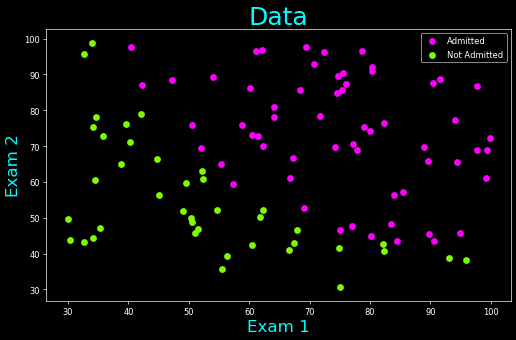

In [7]:
from matplotlib.pyplot import figure

figure(num=None, figsize=(10, 6), dpi=60,)
plt.scatter(admitted['Exam 1'], admitted['Exam 2'], s=10, label='Admitted', linewidth=5, color = 'magenta')
plt.scatter(not_admitted['Exam 1'], not_admitted['Exam 2'], s=10, label='Not Admitted', linewidth=5, color ='lawngreen') 
plt.legend()

plt.xlabel('Exam 1', color='aqua',fontsize=20)
plt.ylabel('Exam 2', color='aqua',fontsize=20)
plt.title('Data', color='aqua',fontsize=30)
plt.show()

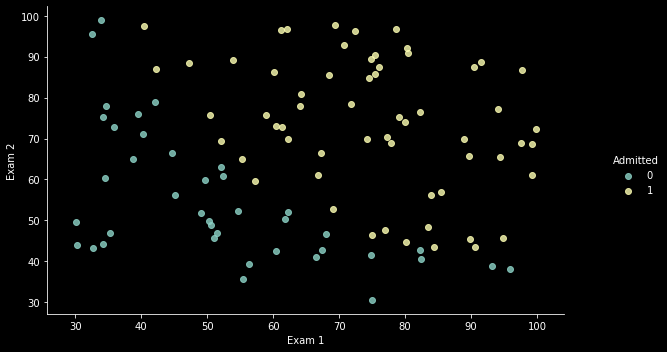

In [8]:
import seaborn as sns

sns.lmplot('Exam 1', 'Exam 2', data, hue='Admitted', fit_reg=False)
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.show()

<a id="section1"></a>
### 1.2 Implementation (30pt)

#### 1.2.1 Warmup exercise: sigmoid function (5pt)

Before you start with the actual cost function, recall that the logistic regression hypothesis is defined as:

$$ h_\theta(x) = g(\theta^T x)$$

where function $g$ is the sigmoid function. The sigmoid function is defined as: 

$$g(z) = \frac{1}{1+e^{-z}}$$.

Your first step is to implement this function `sigmoid` so it can be
called by the rest of your program. When you are finished, try testing a few
values by calling `sigmoid(x)` in a new cell. For large positive values of `x`, the sigmoid should be close to 1, while for large negative values, the sigmoid should be close to 0. Evaluating `sigmoid(0)` should give you exactly 0.5. Your code should also work with vectors and matrices. **For a matrix, your function should perform the sigmoid function on every element.**
<a id="sigmoid"></a>

In [9]:
def sigmoid(z):
    """
    Compute sigmoid function given the input z.
    
    Parameters
    ----------
    z : array_like
        The input to the sigmoid function. This can be a 1-D vector 
        or a 2-D matrix. 
    
    Returns
    -------
    g : array_like
        The computed sigmoid function. g has the same shape as z, since
        the sigmoid is computed element-wise on z.
        
    Instructions
    ------------
    Compute the sigmoid of each value of z (z can be a matrix, vector or scalar).
    """
    # convert input to a numpy array
    z = np.array(z)
    
    # You need to return the following variables correctly 
    g = np.zeros(z.shape)
    # g.shape is (m,)
    # ====================== YOUR CODE HERE ======================
   
    g = 1 / (1 + np.exp(-z))
    
    # =============================================================
    return g

The following cell evaluates the sigmoid function at `z=0`. You should get a value of 0.5. You can also try different values for `z` to experiment with the sigmoid function.

In [10]:
# Test the implementation of sigmoid function here
z = (-10, -3, 0, 1, 500)
g = sigmoid(z)

print('g(', z, ') = ', g)

g( (-10, -3, 0, 1, 500) ) =  [0.0000454  0.04742587 0.5        0.73105858 1.        ]


In [11]:
g.shape

(5,)

Try to plot the sigmoid function.

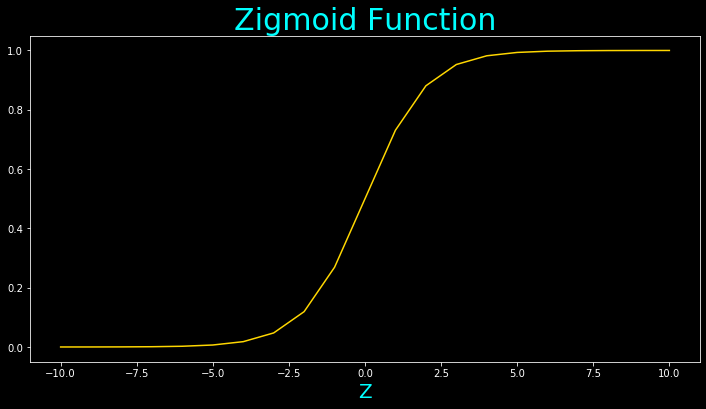

In [12]:
nums = np.arange(-10, 11, step=1)

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(nums, sigmoid(nums), '-', color = 'gold' )
plt.xlabel('Z', color='aqua',fontsize=20)

plt.title('Zigmoid Function', color='aqua',fontsize=30)
plt.show()

<a id="section2"></a>
#### 1.2.2 Cost function and gradient (10pt)

Now you will implement the cost function and gradient for logistic regression. Before proceeding we add the intercept term to X. 

Now, complete the code for the function `costFunction` to return the cost and gradient. Recall that the cost function in logistic regression is

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m} \left[ -y^{(i)} \log\left(h_\theta\left( x^{(i)} \right) \right) - \left( 1 - y^{(i)}\right) \log \left( 1 - h_\theta\left( x^{(i)} \right) \right) \right]$$

and the gradient of the cost is a vector of the same length as $\theta$ where the $j^{th}$
element (for $j = 0, 1, \cdots , n$) is defined as follows:

$$ \frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^m \left( h_\theta \left( x^{(i)} \right) - y^{(i)} \right) x_j^{(i)} $$

Note that while this gradient looks identical to the linear regression gradient, the formula is actually different because linear and logistic regression have different definitions of $h_\theta(x)$.
<a id="costFunction"></a>

-----------------------------------------------------------------------------------------------------------------------------------------------------

### `y(m,) `  is a 1-D aray `array([0, 1, 2, 3])` (like a matrix of `(1,m)`)

### The operator between `h(m,) `and `X(m,n)` must be `@` and not `*` and the result is `(m,)` and has sum of all multplied values insdie it (like matrix multiplication)

### `y(m,) @ h(m,)`  the result is a number (sum of all multiplied values) also it can be done by `np.sum(y * h)`

### `X(m,n) @ y(n,) ` is correct and not `X.T(n,m) @ y(n,) `

According to numpy a 1D array has only 1 dimension and all checks are done against that dimension. Because of this we find that np.dot(A,B) checks second dimension of A against the one dimension of B

in A, which has shape (3,2), we have consumed the last part (2,) to perform sum-product. The un-consumed part of A's shape is (3,), and hence the shape of the result of np.dot(A,B), would be (3,). To understand this further, if we take a different example in which A has a shape of (3,4,2), instead of (3,2), the un-consumed part of A's shape would be (3,4,), and the result of np.dot(A,B) would be (3,4,) instead of (3,) which your example produced.

### EXAMPLES:

In [13]:
x = np.arange(4)
y = np.arange(4,12).reshape(4,2)

x.shape, y.shape

((4,), (4, 2))

In [14]:
print(x)
y

[0 1 2 3]


array([[ 4,  5],
       [ 6,  7],
       [ 8,  9],
       [10, 11]])

In [15]:
x @ y

array([52, 58])

-----------------------------------------------------------------------------------------------------------------------------------------------

In [16]:
def costFunction(theta, X, y):
    """
    Compute cost and gradient for logistic regression. 
    
    Parameters
    ----------
    theta : array_like
        The parameters for logistic regression. This a vector
        of shape (n+1, ).
    
    X : array_like
        The input dataset of shape (m x n+1) where m is the total number
        of data points and n is the number of features. We assume the 
        intercept has already been added to the input.
    
    y : arra_like
        Labels for the input. This is a vector of shape (m, ).
    
    Returns
    -------
    J : float
        The computed value for the cost function. 
    
    grad : array_like
        A vector of shape (n+1, ) which is the gradient of the cost
        function with respect to theta, at the current values of theta.
        
    Instructions
    ------------
    Compute the cost of a particular choice of theta. You should set J to 
    the cost. Compute the partial derivatives and set grad to the partial
    derivatives of the cost w.r.t. each parameter in theta.
    """
    
    # You need to return the following variables correctly 
    cost = 0
    grad = np.zeros(theta.shape)
    
    # ====================== YOUR CODE HERE ======================
    m = X.shape[0]
    h = sigmoid(X @ (theta))
    
    cost = (-1 / m) * (y @ (np.log(h)) + (1 - y) @ (np.log(1 - h)))
    #y and h are treated like matrix despite the fact that theye both are (100,) arrays. like (1,100)
    # so we dont need the sum() operator
    #or:
    # np.sum( y*(np.log(h))+(1-y)*(np.log(1-h)) ) 
    #y and h are arrays and their multiply is an array so we should sum() these elements

    grad = (1 / m) * (h - y) @ X
    # h is (m,) and X(m,n) , the operator between them must be @ and not *
    # =============================================================
    return cost, grad

In [17]:
data

,Exam 1,Exam 2,Admitted
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1
...,...,...,...
95,83.489163,48.380286,1
96,42.261701,87.103851,1
97,99.315009,68.775409,1
98,55.340018,64.931938,1


In [18]:
# add a ones column - this makes the matrix multiplication work out easier( X0 = 1)
data.insert(0, 'Ones', 1)
data

,Ones,Exam 1,Exam 2,Admitted
0,1,34.623660,78.024693,0
1,1,30.286711,43.894998,0
2,1,35.847409,72.902198,0
3,1,60.182599,86.308552,1
4,1,79.032736,75.344376,1
...,...,...,...,...
95,1,83.489163,48.380286,1
96,1,42.261701,87.103851,1
97,1,99.315009,68.775409,1
98,1,55.340018,64.931938,1


In [19]:
# set X (training data) and y (target variable)
cols = data.shape[1]
X = data.iloc[:,0:cols-1]
y = data.iloc[:,cols-1:cols]

In [20]:
X.shape, y.shape

((100, 3), (100, 1))

In [21]:
type(X)

pandas.core.frame.DataFrame

In [22]:
X[:5]

,Ones,Exam 1,Exam 2
0,1,34.623660,78.024693
1,1,30.286711,43.894998
2,1,35.847409,72.902198
3,1,60.182599,86.308552
4,1,79.032736,75.344376


In [23]:
# convert to numpy arrays and initalize the parameter array theta
X = np.array(X.values)
y = np.array(y.values)
initial_theta = np.zeros(3)

In [24]:
X[:10]

array([[ 1.        , 34.62365962, 78.02469282],
       [ 1.        , 30.28671077, 43.89499752],
       [ 1.        , 35.84740877, 72.90219803],
       [ 1.        , 60.18259939, 86.3085521 ],
       [ 1.        , 79.03273605, 75.34437644],
       [ 1.        , 45.08327748, 56.31637178],
       [ 1.        , 61.10666454, 96.51142588],
       [ 1.        , 75.02474557, 46.55401354],
       [ 1.        , 76.0987867 , 87.42056972],
       [ 1.        , 84.43281996, 43.53339331]])

In [25]:
X.shape , y.shape 

((100, 3), (100, 1))

### It's mentioned in the defenition of the costFunction() that y should be an (m, ) array

- The next cell does this conversion 

In [26]:
y = np.squeeze(y) #This line converts y from (100, 1) to (100, )
y.shape

(100,)

In [27]:
type(X)#now X is a matrix

numpy.ndarray

In [28]:
X[:5] 

array([[ 1.        , 34.62365962, 78.02469282],
       [ 1.        , 30.28671077, 43.89499752],
       [ 1.        , 35.84740877, 72.90219803],
       [ 1.        , 60.18259939, 86.3085521 ],
       [ 1.        , 79.03273605, 75.34437644]])

In [29]:
y[:5]


array([0, 0, 0, 1, 1], dtype=int64)

In [30]:
initial_theta.shape

(3,)

Once you are done call your `costFunction` using two test cases for  $\theta$ by executing the next cell.

In [31]:
cost, grad = costFunction(initial_theta, X, y)

print('Cost at initial theta (zeros): {:.3f}'.format(cost))


print('Gradient at initial theta (zeros):')
print('\t[{:.4f}, {:.4f}, {:.4f}]'.format(*grad))


# Compute and display cost and gradient with non-zero theta
test_theta = np.array([-24, 0.2, 0.2])
cost, grad = costFunction(test_theta, X, y)

print('Cost at test theta: {:.3f}'.format(cost))


print('Gradient at test theta:')
print('\t[{:.3f}, {:.3f}, {:.3f}]'.format(*grad))


Cost at initial theta (zeros): 0.693
Gradient at initial theta (zeros):
	[-0.1000, -12.0092, -11.2628]
Cost at test theta: 0.218
Gradient at test theta:
	[0.043, 2.566, 2.647]


In [32]:
cost.shape, grad.shape

#cost is a number, shape:()
#grad is a 1-D array, shape:(3,)

((), (3,))

#### 1.2.3 Learning parameters using `scipy.optimize` (5 pt)

In the previous assignment, you found the optimal parameters of a linear regression model by implementing gradient descent. You wrote a cost function and calculated its gradient, then took a gradient descent step accordingly. This time, instead of taking gradient descent steps, you will use the [`scipy.optimize` module](https://docs.scipy.org/doc/scipy/reference/optimize.html). SciPy is a numerical computing library for `python`. It provides an optimization module for root finding and minimization. As of `scipy 1.0`, the function `scipy.optimize.minimize` is the method to use for optimization problems(both constrained and unconstrained).

For logistic regression, you want to optimize the cost function $J(\theta)$ with parameters $\theta$.
Concretely, you are going to use `optimize.minimize` to find the best parameters $\theta$ for the logistic regression cost function, given a fixed dataset (of X and y values). You will pass to `optimize.minimize` the following inputs:
- `costFunction`: A cost function that, when given the training set and a particular $\theta$, computes the logistic regression cost and gradient with respect to $\theta$ for the dataset (X, y). It is important to note that we only pass the name of the function without the parenthesis. This indicates that we are only providing a reference to this function, and not evaluating the result from this function.
- `initial_theta`: The initial values of the parameters we are trying to optimize.
- `(X, y)`: These are additional arguments to the cost function.
- `jac`: Indication if the cost function returns the Jacobian (gradient) along with cost value. (True)
- `method`: Optimization method/algorithm to use
- `options`: Additional options which might be specific to the specific optimization method. In the following, we only tell the algorithm the maximum number of iterations before it terminates.

If you have completed the `costFunction` correctly, `optimize.minimize` will converge on the right optimization parameters and return the final values of the cost and $\theta$ in a class object. Notice that by using `optimize.minimize`, you did not have to write any loops yourself, or set a learning rate like you did for gradient descent. This is all done by `optimize.minimize`: you only needed to provide a function calculating the cost and the gradient.

In the following, we already have code written to call `optimize.minimize` with the correct arguments.

In [33]:
import scipy 

In [34]:
import scipy 
options= {'maxiter': 400}
estimators = ['TNC','BFGS', 'CG', 'Newton-CG' ]


for estimator in estimators:
    res = scipy.optimize.minimize(fun = costFunction,
                            x0 = initial_theta,
                            args=(X, y),
                            jac = True,
                            options = options,
                            method = estimator 
                               )  

# the fun property of `OptimizeResult` object returns
# the value of costFunction at optimized theta
    cost = res.fun

# the optimized theta is in the x property
    theta = res.x

# Print theta to screen
    print(f"method: {estimator}")
    print('Cost at theta found by opt.minimize: {:.3f}'.format(cost))


    print('theta:')
    print('\t[{:.3f}, {:.3f}, {:.3f}]'.format(*theta))


method: TNC
Cost at theta found by opt.minimize: 0.203
theta:
	[-25.161, 0.206, 0.201]
method: BFGS
Cost at theta found by opt.minimize: 0.203
theta:
	[-25.161, 0.206, 0.201]
method: CG
Cost at theta found by opt.minimize: 0.203
theta:
	[-25.164, 0.206, 0.201]
method: Newton-CG
Cost at theta found by opt.minimize: 0.203
theta:
	[-25.136, 0.206, 0.201]


C:\Users\Behnam\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
C:\Users\Behnam\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in matmul


<a id="section4"></a>
#### 1.2.4 Evaluating logistic regression (10 pt)

After learning the parameters, you can use the model to predict whether a particular student will be admitted. Another way to evaluate the quality of the parameters we have found is to see how well the learned model predicts on our training set. In this part, your task is to complete the code in function `predict`. The predict function will produce “1” or “0” predictions given a dataset and a learned parameter vector $\theta$. 
<a id="predict"></a>

In [35]:
theta

array([-25.1358504 ,   0.20602723,   0.20126608])

### Alternative approach that you can set the threshold with desired values other than 0.5


    sklearn.preprocessing.binarize(list(zip(hypo, 1-hypo)), threshold=0.5)[:,0]

In [36]:
def predict(theta, X):
    """
    Predict whether the label is 0 or 1 using learned logistic regression.
    Computes the predictions for X using a threshold at 0.5 
    (i.e., if sigmoid(theta.T*x) >= 0.5, predict 1)
    
    Parameters
    ----------
    theta : array_like
        Parameters for logistic regression. A vecotor of shape (n+1, ).
    
    X : array_like
        The data to use for computing predictions. The rows is the number 
        of points to compute predictions, and columns is the number of
        features.

    Returns
    -------
    p : array_like
        Predictions and 0 or 1 for each row in X. 
    
    Instructions
    ------------
    Complete the following code to make predictions using your learned 
    logistic regression parameters.You should set p to a vector of 0's and 1's    
    """
    m = X.shape[0] # Number of training examples

    # You need to return the following variables correctly
    p = np.zeros(m)

    # ====================== YOUR CODE HERE ======================
    p = np.round(sigmoid(X@(theta.T)))
    #OR:
    #import sklearn
    #sklearn.preprocessing.binarize(list(zip(hypo, 1-hypo)), threshold=0.5)[:,0]
    # ============================================================
    return p

After you have completed the code in `predict`, we proceed to report the training accuracy of your classifier by computing the percentage of examples it got correct.

In [37]:
X.shape, theta.shape, y.shape

((100, 3), (3,), (100,))

In [38]:
#  Predict probability for a student with score 45 on exam 1 
#  and score 85 on exam 2 
prob = sigmoid(np.dot([1, 45, 85], theta))
print('For a student with scores 45 and 85,'
      'we predict an admission probability of {:.3f}'.format(prob))


# Compute accuracy on our training set

p = np.matrix(predict(theta, X))
print('Train Accuracy: {:.2f} %'.format(np.mean(p == y) * 100))


For a student with scores 45 and 85,we predict an admission probability of 0.776
Train Accuracy: 89.00 %


In [39]:
p.shape

(1, 100)

In [40]:
y.shape
#It can be treated like (1,100) array

(100,)

In [41]:
y

array([0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

## 2 Regularized logistic regression (40 pt)

In this part of the exercise, you will implement regularized logistic regression to predict whether microchips from a fabrication plant passes quality assurance (QA). During QA, each microchip goes through various tests to ensure it is functioning correctly.
Suppose you are the product manager of the factory and you have the test results for some microchips on two different tests. From these two tests, you would like to determine whether the microchips should be accepted or rejected. To help you make the decision, you have a dataset of test results on past microchips, from which you can build a logistic regression model.

First, we load the data from a CSV file:

In [42]:
# Load Data
path =  r'C:\Users\Behnam\Downloads\Python\Datasets\ML_HW2\ex2data2.txt'
data2 = pd.read_csv(path, header=None, names=['Test 1', 'Test 2', 'Accepted'])
data2.head()

,Test 1,Test 2,Accepted
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


### 2.1 Visualizing the data (5 pt)

Before starting to implement any learning algorithm, it is always good to visualize the data if possible. Write codes below to display a figure where the axes are the two exam scores, and the positive and negative examples are shown with different markers.

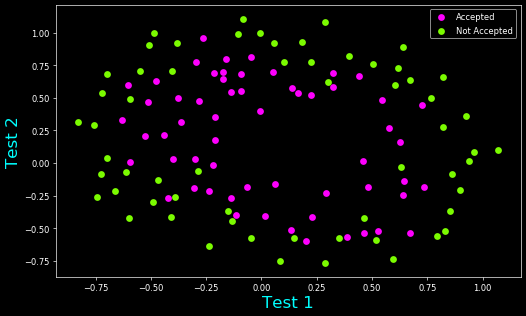

In [43]:
Accepted = data2.loc[data2.Accepted == 1]
# filter out the Admitted Stuents 

not_Accepted = data2.loc[data2.Accepted == 0]
# filter out the not Admitted Students

from matplotlib.pyplot import figure

figure(num=None, figsize=(10, 6), dpi=60,)
plt.scatter(Accepted['Test 1'], Accepted['Test 2'], s=10, label='Accepted', linewidth=5, color = 'magenta')
plt.scatter(not_Accepted['Test 1'], not_Accepted['Test 2'], s=10, label='Not Accepted', linewidth=5, color ='lawngreen') 
plt.legend()

plt.xlabel('Test 1', color='aqua',fontsize=20)
plt.ylabel('Test 2', color='aqua',fontsize=20)

plt.show()

The above figure shows that our dataset cannot be separated into positive and negative examples by a straight-line through the plot. Therefore, a straight-forward application of logistic regression will not perform well on this dataset since logistic regression will only be able to find a linear decision boundary.

### 2.2 Feature mapping (10 pt)

One way to fit the data better is to create more features from each data point. Next, we will map the features into all polynomial terms of $x_1$ and $x_2$ up to the sixth power:

$$ \begin{bmatrix} 1 & x_1 & x_2 & x_1^2 & x_1 x_2 & x_2^2 & x_1^3 & \dots & x_1 x_2^5 & x_2^6 \end{bmatrix} $$

As a result of this mapping, our vector of two features (the scores on two QA tests) has been transformed into a 28-dimensional vector. A logistic regression classifier trained on this higher-dimension feature vector will have a more complex decision boundary and will appear nonlinear when drawn in our 2-dimensional plot.
While the feature mapping allows us to build a more expressive classifier, it also more susceptible to overfitting. In the next parts of the exercise, you will implement regularized logistic regression to fit the data and also see for yourself how regularization can help combat the overfitting problem.

Write codes below to create a new dataframe with all 28 features.


In [44]:
data2

,Test 1,Test 2,Accepted
0,0.051267,0.699560,1
1,-0.092742,0.684940,1
2,-0.213710,0.692250,1
3,-0.375000,0.502190,1
4,-0.513250,0.465640,1
...,...,...,...
113,-0.720620,0.538740,0
114,-0.593890,0.494880,0
115,-0.484450,0.999270,0
116,-0.006336,0.999270,0


In [45]:
#Creating X2 and y2 out the data dataframe
X2 = data2[['Test 1', 'Test 2']]
y2 = data2['Accepted']

In [46]:
type(y2)

pandas.core.series.Series

In [47]:
# Converting X2 and y2 into np.arrays
X2 = np.array(X2.values)
y2 = np.array(y2.values)

In [48]:
X2.shape, y2.shape

((118, 2), (118,))

In [49]:
X2[1]

array([-0.092742,  0.68494 ])

### This function adds features of differents degrees

`degree = 7
x1 = data2['Test 1']
x2 = data2['Test 2']
for i in range(0, degree):
    for j in range(0, i+1):
        data2['F' + str(i) + str(j)] = np.power(x1, i-j) * np.power(x2, j)
data2.drop('Test 1', axis=1, inplace=True)
data2.drop('Test 2', axis=1, inplace=True)
data2.head()`

In [50]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(6) #Creates a object for new features upto degree of 6 out of initial features(for X)
X2 = poly.fit_transform(X2) # Apply this new object to X
# Note that this function inserts a column with 'ones' in the X array for the intercept.

X2[1]

array([ 1.        , -0.092742  ,  0.68494   ,  0.00860108, -0.06352271,
        0.4691428 , -0.00079768,  0.00589122, -0.04350924,  0.32133467,
        0.00007398, -0.00054636,  0.00403513, -0.02980122,  0.22009497,
       -0.00000686,  0.00005067, -0.00037423,  0.00276382, -0.02041205,
        0.15075185,  0.00000064, -0.0000047 ,  0.00003471, -0.00025632,
        0.00189305, -0.01398103,  0.10325597])

In [51]:
X2.shape

(118, 28)

### Now we have 28 features including a column of 1

In [52]:
y2.shape

(118,)

<a id="section5"></a>
### 2.3 Cost function and gradient (15 pt)

Now you will implement code to compute the cost function and gradient for regularized logistic regression. Complete the code for the function `costFunctionReg` below to return the cost and gradient.

The regularized cost function in logistic regression is

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^m \left[ -y^{(i)}\log \left( h_\theta \left(x^{(i)} \right) \right) - \left( 1 - y^{(i)} \right) \log \left( 1 - h_\theta \left( x^{(i)} \right) \right) \right] + \frac{\lambda}{2m} \sum_{j=1}^n \theta_j^2 $$

Note that you should not regularize the parameters $\theta_0$. The gradient of the cost function is a vector where the $j^{th}$ element is defined as follows:

$$ \frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m} \sum_{i=1}^m \left( h_\theta \left(x^{(i)}\right) - y^{(i)} \right) x_j^{(i)} \qquad \text{for } j =0 $$

$$ \frac{\partial J(\theta)}{\partial \theta_j} = \left( \frac{1}{m} \sum_{i=1}^m \left( h_\theta \left(x^{(i)}\right) - y^{(i)} \right) x_j^{(i)} \right) + \frac{\lambda}{m}\theta_j \qquad \text{for } j \ge 1 $$
<a id="costFunctionReg"></a>

In [53]:
def costFunctionReg(theta, X, y, lambda_):
    """
    Compute cost and gradient for logistic regression with regularization.
    
    Parameters
    ----------
    theta : array_like
        Logistic regression parameters. A vector with shape (n, ). n is 
        the number of features including any intercept. If we have mapped
        our initial features into polynomial features, then n is the total 
        number of polynomial features. 
    
    X : array_like
        The data set with shape (m x n). m is the number of examples, and
        n is the number of features (after feature mapping).
    
    y : array_like
        The data labels. A vector with shape (m, ).
    
    lambda_ : float
        The regularization parameter. 
    
    Returns
    -------
    J : float
        The computed value for the regularized cost function. 
    
    grad : array_like
        A vector of shape (n, ) which is the gradient of the cost
        function with respect to theta, at the current values of theta.
    
    Instructions
    ------------
    Compute the cost `J` of a particular choice of theta.
    Compute the partial derivatives and set `grad` to the partial
    derivatives of the cost w.r.t. each parameter in theta.
    """
    # Initialize some useful values
    m = y.size  # number of training examples

    # You need to return the following variables correctly 
    cost = 0
    grad = np.zeros(theta.shape)

    # ===================== YOUR CODE HERE ======================
    m = X.shape[0]
    h = sigmoid(X @ (theta)) #first we calculate h with give theta
    theta[0] = 0 #then we set theta[0]=0 Because we want to make regularization term for theta[0] = 0
  
    cost = (-1 / m) * (y@(np.log(h)) + (1 - y)@(np.log(1 - h))) + lambda_/(2*m)*np.sum(np.square(theta))

    grad = (1 / m) * (h - y) @ X + (lambda_/m)*theta
    
    
    # =============================================================
    return cost, grad

### To check all the dimensions 

In [54]:
initial_theta = np.zeros(X2.shape[1])
h = sigmoid(X2 @ (initial_theta))
m = y2.size

grad = (1 / m) * (h - y2) @ X2 + (1/m)*initial_theta
h.shape, y2.shape, X2.shape, grad.shape, initial_theta.shape

((118,), (118,), (118, 28), (28,), (28,))

Once you are done with the `costFunctionReg`, we call it below using the initial value of $\theta$ (initialized to all zeros), and also another test case where $\theta$ is all ones.

In [55]:
# Initialize fitting parameters
initial_theta = np.zeros(X2.shape[1])

# Set regularization parameter lambda to 1
# DO NOT use `lambda` as a variable name in python
# because it is a python keyword
lambda_ = 1

# Compute and display initial cost and gradient for regularized logistic
# regression
cost, grad = costFunctionReg(initial_theta, X2, y2, lambda_)

print('Cost at initial theta (zeros): {:.3f}'.format(cost))


print('Gradient at initial theta (zeros) - first five values only:')
print('\t[{:.4f}, {:.4f}, {:.4f}, {:.4f}, {:.4f}]'.format(*grad[:5]))



# Compute and display cost and gradient
# with all-ones theta and lambda = 10
test_theta = np.ones(X2.shape[1])
cost, grad = costFunctionReg(test_theta, X2, y2, 10)

print('------------------------------------------------------------\n')
print('Cost at test theta (Ones)   : {:.2f}'.format(cost))


print('Gradient at test theta (Ones) - first five values only:')
print('\t[{:.4f}, {:.4f}, {:.4f}, {:.4f}, {:.4f}]'.format(*grad[:5]))


Cost at initial theta (zeros): 0.693
Gradient at initial theta (zeros) - first five values only:
	[0.0085, 0.0188, 0.0001, 0.0503, 0.0115]
------------------------------------------------------------

Cost at test theta (Ones)   : 3.16
Gradient at test theta (Ones) - first five values only:
	[0.3460, 0.1614, 0.1948, 0.2269, 0.0922]


### 2.4 Learning parameters using `scipy.optimize.minimize` (5 pt)

Similar to the previous parts, you will use `opt.minimize` to learn the optimal parameters $\theta$. If you have completed the cost and gradient for regularized logistic regression (`costFunctionReg`) correctly, you should be able to step through the next part of to learn the parameters $\theta$ using `opt.minimize`.

In [56]:
# set options for optimize.minimize
options= {'maxiter': 400}

# see documention for scipy's optimize.minimize  for description about
# the different parameters
# The function returns an object `OptimizeResult`
# We use truncated Newton algorithm for optimization

#lambda_ = 1
# ===================== YOUR CODE HERE ======================
import scipy
options= {'maxiter': 400}
methods = ['TNC', 'CG', 'Newton-CG', 'L-BFGS-B' ,'BFGS']
lambda_s = [0.1,  100, 1]

for method in methods:
    print('------------------------------------------------')
    print(f'Accuracy for {method}')
    for lambda_ in lambda_s:
        res = scipy.optimize.minimize(fun = costFunctionReg,
                                    x0 = initial_theta,
                                    args=(X2, y2, lambda_),
                                    jac = True,
                                    options = options,
                                    method = method
                                       )
        cost = res.fun
        theta = res.x
        p2 = np.matrix(predict(theta, X2))
        
        print(f'lambda = {lambda_:>3}: %.1f %%' % (np.mean(p2 == y2) * 100))
     
    # =============================================================



------------------------------------------------
Accuracy for TNC
lambda = 0.1: 66.1 %
lambda = 100: 53.4 %
lambda =   1: 66.1 %
------------------------------------------------
Accuracy for CG
lambda = 0.1: 83.9 %
lambda = 100: 61.0 %
lambda =   1: 83.1 %
------------------------------------------------
Accuracy for Newton-CG
lambda = 0.1: 56.8 %
lambda = 100: 53.4 %
lambda =   1: 55.1 %
------------------------------------------------
Accuracy for L-BFGS-B
lambda = 0.1: 41.5 %
lambda = 100: 53.4 %
lambda =   1: 55.1 %
------------------------------------------------
Accuracy for BFGS
lambda = 0.1: 83.9 %
lambda = 100: 61.0 %
lambda =   1: 83.1 %


C:\Users\Behnam\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log
C:\Users\Behnam\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in matmul
C:\Users\Behnam\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: overflow encountered in exp


### As you can see, increasing $\lambda$ will decrease the accuracy.

In [57]:
theta

array([ 1.27268739,  0.62557016,  1.1809665 , -2.01919822, -0.91761468,
       -1.43194199,  0.12375921, -0.36513086, -0.35703388, -0.17485805,
       -1.45843772, -0.05129676, -0.61603963, -0.2746414 , -1.19282569,
       -0.24270336, -0.20570022, -0.04499768, -0.27782709, -0.29525851,
       -0.45613294, -1.04377851,  0.02762813, -0.29265642,  0.01543393,
       -0.32759318, -0.14389199, -0.92460119])

<a id="section4"></a>
### 2.5 Evaluating logistic regression (5 pt)

In this part, your task is to complete the code in function `predict`. The predict function will produce “1” or “0” predictions given a dataset and a learned parameter vector $\theta$. 
<a id="predict"></a>

In [58]:
def predict(theta, X):
    """
    Predict whether the label is 0 or 1 using learned logistic regression.
    Computes the predictions for X using a threshold at 0.5 
    (i.e., if sigmoid(theta.T*x) >= 0.5, predict 1)
    
    Parameters
    ----------
    theta : array_like
        Parameters for logistic regression. A vecotor of shape (n+1, ).
    
    X : array_like
        The data to use for computing predictions. The rows is the number 
        of points to compute predictions, and columns is the number of
        features.

    Returns
    -------
    p : array_like
        Predictions and 0 or 1 for each row in X. 
    
    Instructions
    ------------
    Complete the following code to make predictions using your learned 
    logistic regression parameters.You should set p to a vector of 0's and 1's    
    """
    m = X.shape[0] # Number of training examples

    # You need to return the following variables correctly
    p = np.zeros(m)

    # ====================== YOUR CODE HERE ======================
    
    p = np.round(sigmoid(X@(theta.T)))
    
    # ============================================================
    return p

After you have completed the code in `predict`, we proceed to report the training accuracy of your classifier by computing the percentage of examples it got correct.

In [59]:
X2.shape, theta.shape, y2.shape

((118, 28), (28,), (118,))

In [60]:
# Compute accuracy on our training set
p2 = np.matrix(predict(theta, X2))
print('Train Accuracy: %.1f %%' % (np.mean(p2 == y2) * 100))

Train Accuracy: 83.1 %


In [61]:
p2

matrix([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
         1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
         1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 1.]])

In [62]:
y2

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

### 2.6 Optional (ungraded) exercises

In this part of the exercise, you can try out different regularization parameters for the dataset to understand how regularization prevents overfitting.

Notice the changes in the decision boundary as you vary $\lambda$. With a small
$\lambda$, you should find that the classifier gets almost every training example correct, but draws a very complicated boundary, thus overfitting the data. See the following figures for the decision boundaries you should get for different values of $\lambda$. 

<table>
    <tr>
        <td style="text-align:center">
            No regularization (overfitting)<img src="Figures/decision_boundary3.png">
        </td>        
        <td style="text-align:center">
            Decision boundary with regularization
            <img src="Figures/decision_boundary2.png">
        </td>
        <td style="text-align:center">
            Decision boundary with too much regularization
            <img src="Figures/decision_boundary4.png">
        </td>        
    <tr>
</table>

This is not a good decision boundary in the first figure: for example, it predicts that a point at $x = (−0.25, 1.5)$ is accepted $(y = 1)$, which seems to be an incorrect decision given the training set.
With a larger $\lambda$, you should see a plot that shows an simpler decision boundary which still separates the positives and negatives fairly well. However, if $\lambda$ is set to too high a value, you will not get a good fit and the decision boundary will not follow the data so well, thus underfitting the data.

<a id="section7"></a>
## 3 Scikit-learn (20pt)

In this part, you need to use scikit-learn to find $\theta$ for part 1 and 2, and compare with the ones you have found before. You should also verify the accuracy scores. 

## **3.1**

In [63]:
path = r'C:\Users\Behnam\Downloads\Python\Datasets\ML_HW2\ex2data1.txt'
data = pd.read_csv(path, header=None, names=['Exam 1', 'Exam 2', 'Admitted'])
data.head()

,Exam 1,Exam 2,Admitted
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


In [64]:
data = data[['Admitted','Exam 1', 'Exam 2']]
data

,Admitted,Exam 1,Exam 2
0,0,34.623660,78.024693
1,0,30.286711,43.894998
2,0,35.847409,72.902198
3,1,60.182599,86.308552
4,1,79.032736,75.344376
...,...,...,...
95,1,83.489163,48.380286
96,1,42.261701,87.103851
97,1,99.315009,68.775409
98,1,55.340018,64.931938


In [65]:
target = 'Admitted'
predictors = data.columns[1:]

In [66]:
y = data[target]
X = data[predictors]

In [67]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression().fit(X, y)
clf

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [68]:
print(f"Score when whole dataset is given for train and test: {clf.score(X, y):0.3f}")

Score when whole dataset is given for train and test: 0.890


First, we gave all the sample data for train and test and the accuracy is  0.89 which is simillar to what we've calculated before but it's not a good practice, we shouldn't give all data set for train and test. 

In [69]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify = y, random_state = 2)

In [70]:
clf2 = LogisticRegression().fit(X_train, y_train)
clf2

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Then we give only train set to create and test set to the evaluate the model and as expected, the accuracy score has decreased

In [71]:
print(f"Score for seperate train and test sets: {clf2.score(X_test, y_test)}")

Score for seperate train and test sets: 0.84


In [72]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler, RobustScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_validate

pipe = make_pipeline( MinMaxScaler(), PolynomialFeatures(degree=6), LogisticRegression(max_iter = 1000) )

pipe.fit(X_train, y_train)

scores = cross_validate(pipe, X, y, cv=3, return_train_score=True, scoring = 'roc_auc')
df_scores = pd.DataFrame(scores)
df_scores

,fit_time,score_time,test_score,train_score
0,0.008976,0.005983,0.925000,0.977885
1,0.007976,0.002993,0.984615,0.957407
2,0.008977,0.001995,0.969231,0.969444


In [73]:
df_scores.mean()

fit_time       0.008643
score_time     0.003657
test_score     0.959615
train_score    0.968245
dtype: float64

### Now we want to add a Gridsearch to find the best parameters for 1 estimator:


In [74]:
pipe2= make_pipeline( StandardScaler(), PolynomialFeatures(), SVC())

param_grid = { 'standardscaler': [MinMaxScaler(), RobustScaler() ],
               'polynomialfeatures__degree' : [1,2,3],
               'svc__C': [0.001, 0.01, 0.1, 1, 10, 100],
              
             }

grid2 = GridSearchCV(pipe2, param_grid, cv=3)
grid2.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('polynomialfeatures',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=True,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('svc',
                                        SVC(C=1.0, break_ties=False,
                                            cache_size=200, class_weight=None,
                                            coef0=0.0,
                                      

### Many estimators:

In [75]:
pipe = Pipeline([('preprocessing', MinMaxScaler() ),
                 ('preprocessing2', PolynomialFeatures()),
                  ('classifier', SVC()) ])


param_grid = [
    {'classifier': [SVC()],
     'preprocessing': [StandardScaler(), RobustScaler()], 
     'preprocessing2__degree' : [2,3,4],
     'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
     'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]},
    {'classifier': [LogisticRegression(max_iter=1000)],
     'preprocessing': [StandardScaler(), RobustScaler()], 
     'preprocessing2__degree' : [2,3,4],
     'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]}]

In [76]:
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessing',
                                        MinMaxScaler(copy=True,
                                                     feature_range=(0, 1))),
                                       ('preprocessing2',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=True,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('classifier',
                                        SVC(C=1.0, break_ties=False,
                                            cache_size=200, class_weight=None,
                                            coef0=0.0,
                                            decision_function_shape='ovr',
                             

In [77]:
df_grid = pd.DataFrame(grid.cv_results_)
df_grid.sort_values(by=['rank_test_score']).set_index('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__C,param_classifier__gamma,param_preprocessing,param_preprocessing2__degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score
rank_test_score,,,,,,,,,,,,,,,,,
1,0.013564,0.001198,0.001400,0.000490,"LogisticRegression(C=10, class_weight=None, du...",100,NaN,"StandardScaler(copy=True, with_mean=True, with...",2,"{'classifier': LogisticRegression(C=10, class_...",1.0,1.000000,1.0,0.933333,1.000000,0.986667,0.026667
1,0.016556,0.001017,0.002394,0.000799,"LogisticRegression(C=10, class_weight=None, du...",10,NaN,"StandardScaler(copy=True, with_mean=True, with...",4,"{'classifier': LogisticRegression(C=10, class_...",1.0,1.000000,1.0,0.933333,1.000000,0.986667,0.026667
3,0.022339,0.005970,0.002993,0.001092,"LogisticRegression(C=10, class_weight=None, du...",100,NaN,"RobustScaler(copy=True, quantile_range=(25.0, ...",4,"{'classifier': LogisticRegression(C=10, class_...",1.0,0.933333,1.0,0.933333,1.000000,0.973333,0.032660
3,0.013761,0.000745,0.001396,0.000488,"LogisticRegression(C=10, class_weight=None, du...",100,NaN,"RobustScaler(copy=True, quantile_range=(25.0, ...",2,"{'classifier': LogisticRegression(C=10, class_...",1.0,1.000000,1.0,0.933333,0.933333,0.973333,0.032660
3,0.006583,0.001353,0.001994,0.000002,"SVC(C=1.0, break_ties=False, cache_size=200, c...",10,0.1,"RobustScaler(copy=True, quantile_range=(25.0, ...",4,"{'classifier': SVC(C=1.0, break_ties=False, ca...",1.0,1.000000,1.0,0.866667,1.000000,0.973333,0.053333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,0.005786,0.001163,0.001797,0.000744,"SVC(C=1.0, break_ties=False, cache_size=200, c...",0.1,10,"RobustScaler(copy=True, quantile_range=(25.0, ...",4,"{'classifier': SVC(C=1.0, break_ties=False, ca...",0.6,0.600000,0.6,0.600000,0.600000,0.600000,0.000000
132,0.004790,0.000743,0.001992,0.000889,"SVC(C=1.0, break_ties=False, cache_size=200, c...",0.1,100,"StandardScaler(copy=True, with_mean=True, with...",2,"{'classifier': SVC(C=1.0, break_ties=False, ca...",0.6,0.600000,0.6,0.600000,0.600000,0.600000,0.000000
132,0.005386,0.001196,0.001995,0.000630,"SVC(C=1.0, break_ties=False, cache_size=200, c...",0.1,100,"StandardScaler(copy=True, with_mean=True, with...",3,"{'classifier': SVC(C=1.0, break_ties=False, ca...",0.6,0.600000,0.6,0.600000,0.600000,0.600000,0.000000


In [78]:
grid.best_params_

{'classifier': LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=1000,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 'classifier__C': 10,
 'preprocessing': StandardScaler(copy=True, with_mean=True, with_std=True),
 'preprocessing2__degree': 4}

,fit_time,score_time,test_score,train_score
0,15.107608,0.002992,0.960714,1.000000
1,15.224296,0.009975,1.000000,0.999074
2,14.733606,0.005985,0.992308,0.992593


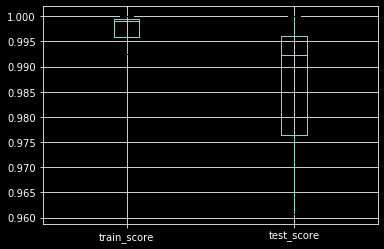

In [79]:
scores = pd.DataFrame(cross_validate(grid, X, y, cv=3, n_jobs=-1,scoring='roc_auc', return_train_score=True))
scores[['train_score', 'test_score']].boxplot()
df_scores = pd.DataFrame(scores)
df_scores

### AUC without cross validation

In [80]:
from sklearn.metrics import roc_auc_score

y_pred_proba = grid.predict_proba(X_test)[:,1]
print(f"The AUC score without cross validation is: {roc_auc_score(y_test, y_pred_proba):0.3f}")

The AUC score without cross validation is: 1.000


## **3.2**

In [81]:
# Load Data
path =  r'C:\Users\Behnam\Downloads\Python\Datasets\ML_HW2\ex2data2.txt'
data2 = pd.read_csv(path, header=None, names=['Test 1', 'Test 2', 'Accepted'])
data2.head()

,Test 1,Test 2,Accepted
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


In [82]:
data2 = data2[['Accepted', 'Test 1', 'Test 2']]
data2

,Accepted,Test 1,Test 2
0,1,0.051267,0.699560
1,1,-0.092742,0.684940
2,1,-0.213710,0.692250
3,1,-0.375000,0.502190
4,1,-0.513250,0.465640
...,...,...,...
113,0,-0.720620,0.538740
114,0,-0.593890,0.494880
115,0,-0.484450,0.999270
116,0,-0.006336,0.999270


In [83]:
target = 'Accepted'
predictors = data2.columns[1:]

In [84]:
y2 = data2[target]
X2 = data2[predictors]

In [85]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size = 0.25, random_state = 5)

### Scaling the features

In [86]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Creating polynomial features

In [87]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(6) #Creates new features upto degree of 6 out of initial features(for X)
X_train = poly.fit_transform(X_train)
X_test = poly.transform(X_test)

In [88]:
X_train.shape

(88, 28)

## Crossvalidation:

#### No need to train the model before cross validation!

>Because it's a Classification problem , we need to set the scoring to 'accuracy'

In [89]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

In [90]:
estimators = {
    'Logistic Regression C=0.01': LogisticRegression(C=0.01, max_iter=10000),
    'Logistic Regression C=1': LogisticRegression(),
    'Logistic Regression C=100': LogisticRegression(C=100, max_iter=10000),
    'Logistic Regression L1': LogisticRegression(solver='saga', penalty = 'l1', max_iter=10000),
    'Gradient Boosting' : GradientBoostingClassifier(n_estimators=500, learning_rate=0.01),
    'Random Forest' : RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
}


In [91]:
from sklearn.model_selection import KFold, cross_val_score

for estimator_name, estimator_object in estimators.items():
     kfold = KFold(n_splits=4, random_state=4 , shuffle=True)
     scores = cross_val_score(estimator_object, X_train, y_train, cv=kfold, scoring='accuracy')
     
     print(f'{estimator_name:>27}: ' + f'mean of accuracy scores = {scores.mean():.3f}')

 Logistic Regression C=0.01: mean of accuracy scores = 0.784
    Logistic Regression C=1: mean of accuracy scores = 0.773
  Logistic Regression C=100: mean of accuracy scores = 0.750
     Logistic Regression L1: mean of accuracy scores = 0.773
          Gradient Boosting: mean of accuracy scores = 0.761
              Random Forest: mean of accuracy scores = 0.727


### The best model has $l_2$ penalty  with $C=0.01$, now we train the model with all train set


In [92]:
clf_final = LogisticRegression(C=0.01, max_iter=10000).fit(X_train, y_train)
clf_final

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [93]:
print(f"Score for seperate test set: {clf_final.score(X_test, y_test) :0.3f}")

Score for seperate test set: 0.833


### Final result is a model with $83$% accuracy on test dataset.


### All in one pipeline

In [94]:
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.svm import SVC

pipe = make_pipeline(StandardScaler(),  PolynomialFeatures(6), SVC() )
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('polynomialfeatures',
                 PolynomialFeatures(degree=6, include_bias=True,
                                    interaction_only=False, order='C')),
                ('svc',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='rbf', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [95]:
scores = cross_validate(pipe, X, y, cv=3, scoring = 'roc_auc',return_train_score=True)
df_scores = pd.DataFrame(scores)
df_scores

,fit_time,score_time,test_score,train_score
0,0.035904,0.010971,0.957143,0.987500
1,0.006983,0.003988,0.892308,0.983333
2,0.007988,0.003980,0.957692,0.980556


In [96]:
df_scores.mean()

fit_time       0.016958
score_time     0.006313
test_score     0.935714
train_score    0.983796
dtype: float64